# Multiarm Bandit

# Basic Imports

In [ ]:
from typing import Iterable
import random

import numpy as np
import matplotlib.pyplot as plt

from tqdm import trange


## The Environment — Process Model

### Simulating one Bandit

In [ ]:
class Bandit:
    """A bandit with uniform reward distribution."""

    def __init__(self, mean: float, span: float): # srednja vrednost i opseg prosledjujemo
        """Initialize the bandit.

        Regardless of the received action, the bandit will return reward
        uniformly sampled from segment [`mean`-`span`, `mean`+`span`].

        Args:
            mean (float): Mean (expected) value of the reward.
            span (float): Span of the reward.
        """
        self.mean = mean
        self.span = span

    def pull_leaver(self) -> float: #povuci rucicu
        """Pull leaver and obtain reward.

        Returns:
            float: The obtained reward.
        """
        return self.mean + 2*self.span * (random.random()-0.5) # random number in [mean-span, mean+span]  u opsegu od 0 do 1 oduzmemo -05

### Testing one Bandit

We should always test a piece of code :) This is not a formal test, but it is still a test.

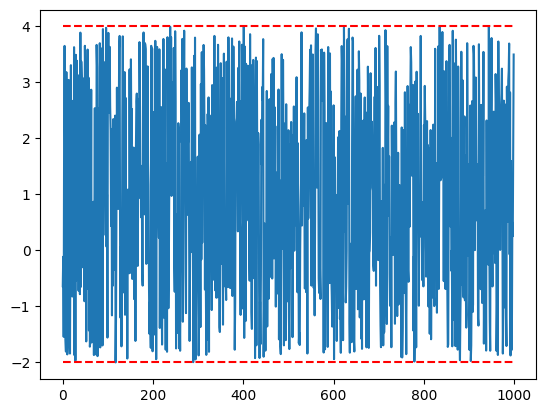

In [ ]:
test_mean = 1.0
test_span = 3.0
test_len = 1000 # hiljadu puta povlacimo rucicu
# kroz 1000 iteracija generise neki random broj

test_bandit = Bandit(test_mean, test_span)
test_rewards = [test_bandit.pull_leaver() for _ in range(test_len)]

plt.plot(test_rewards, label="rewards")
plt.plot((test_mean+test_span)*np.ones(test_len), linestyle="--", color="r")
plt.plot((test_mean-test_span)*np.ones(test_len), linestyle="--", color="r")

### Building an Environment of Bandits

Now, we define an environment consisting of several bandits.

In [ ]:
class BanditsEnvironment:
    """An environment consisting of multiple bandits."""

    def __init__(self, bandits: Iterable[Bandit], penalty=1000): # pravimo okruzenje koje prima listu bandita, iterativan objekat bandita, i trazimo kaznu da bi kaznjavali lose postupke
        """Initialize the environment.

        Args:
            bandits (iter[Bandit]): Bandits to be used within the environment.
            penalty (int, optional):
                If the external agents attempts to use a bandit not in the list,
                i.e. if the chosen action is negative or bigger than the index of
                the last bandit, the returned reward will be `-penalty`. Defaults to 1000.
        """
        self.bandits: list[Bandit] = list(bandits)
        self.penalty = penalty

    def take_action(self, a: int): # akcija je da izaberemo bandita tj redni broj bandita u listi
        """
        Select bandit `a` and pull its leaver.

        If the selected agent is valid, return the obtained reward.
        Otherwise, return negative penalty.
        """
        if a<0 or a>=len(self.bandits): # ne moze negativan indeks ili da prevazilazi listu, kaznice ga
            return -self.penalty
        else:
            return self.bandits[a].pull_leaver() # u suprotnom on ce povuci rucicu, kada povuce dobija nagradu ili kaznu zavisno od ishoda

<div class="alert alert-block alert-info">
<b>Tip:</b>
The `Sequence` and `Iterable` **abstract base classes** (can also be used as **type annotations**) usually adhere to the following conventions:

* `Iterable` is any object that defines `__iter__` or `__getitem__`.
* `Sequence` is any object that defines `__getitem__` and `__len__`. By definition, any sequence is an iterable.

The `Sequence` class also defines other methods such as `__contains__`, `__reversed__` that calls the two required methods.

`list`, `tuple`, `str` are the most common sequences. Some built-in iterables are not sequences.
</div>

For more tips and tricks regarding notebook markdown, please see [here](https://towardsdatascience.com/modernize-your-sinful-python-code-with-beautiful-type-hints-4e72e98f6bf1).


### Testing the Environment

Let us now test the environment. We will build it so that the mean value of the reward returned by each bandit is equal to the square of its index. The span will be equal to the index.

In [ ]:
test_env_size = 5 # pravikmo okruzenje koje ima 5 bandita
test_bandits = [Bandit(i**2, i) for i in range(test_env_size)] # bitno je proslediti srednju vrednost i spend, ovo je kreiranje 5 bandita i smestanje u listu
test_env = BanditsEnvironment(test_bandits) # prosledili ih okruzenju, time smo napravili okruzenje bandita

We will first test whether one of the bandits behaves as expected...

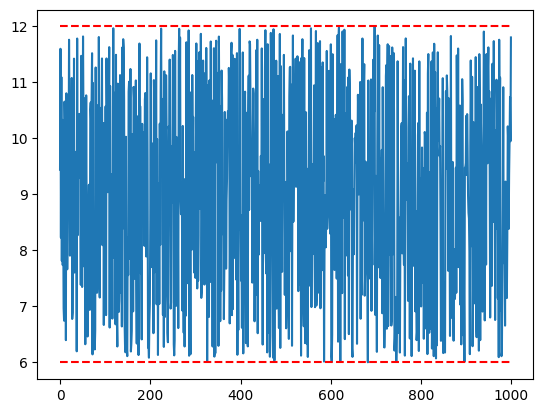

In [ ]:
selected_bandit = 3 # testiramo da li se ponasa kako zelimo
test_len = 1000
test_rewards = [test_env.take_action(selected_bandit) for _ in range(test_len)]

plt.plot(test_rewards, label="rewards")
plt.plot((selected_bandit**2+selected_bandit)*np.ones(test_len), linestyle="--", color="r")
plt.plot((selected_bandit**2-selected_bandit)*np.ones(test_len), linestyle="--", color="r")
# imamo zeljeno ponasanje birali smo uvek jednog te istog bandita

Then, we will test if the environment behaves correctly when an invalid action is given...

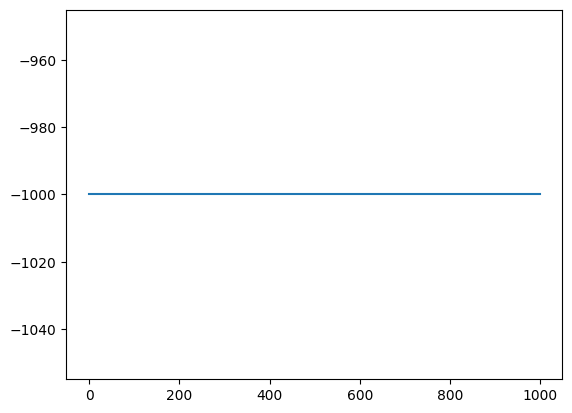

In [ ]:
selected_bandit = -1 # gledamo kako ce se ponasati ako koristimo bandita koji ne postoji
test_rewards = [test_env.take_action(selected_bandit) for _ in range(test_len)]

plt.plot(test_rewards, label="rewards")
#kaznjava nas 1000 puta je bandit ne postoji i dobijamo rezultat -1000

Finally, let us check if the code runs with arbitrarily selected actions. This is quite tricky to do, since the whole system behaves stochastically. However, we know that the bandits are independent, and also that their mean values are 0, 1, 4, 9, and 16. Assuming each bandit is activated with the same probability, the mean value rewards obtained after many actions should be (0 + 1 + 4 + 9 + 16)/5 = 6.

In [ ]:
# proverava da vidimo koliko ce biti nasa ukupna dobit
# nasa ocekivana vrednost svih bi trebala da bude zbir srednjih vrednosti
test_rewards = [test_env.take_action(random.randint(0, 4)) for _ in range(test_len)]
test_mean = sum(test_rewards)/test_len

print("TEST MEAN = ", test_mean)
# dobijamo blizu ocekivanje vrednosti (6)

TEST MEAN =  6.216877672058747


## Decision Policies

In [ ]:
# definisanje politika odlucivanja, ovo je pohlepna politika odlucivanja
# imamo neku info o tome koji bandit daje najvecu dobit, pohlepna forsira tog bandita koji daje najvicu korist
# forsira ga jer je najbolji banddit i ona je eksploitivna politika, nece saznati nista o okolini, nece saznati da li je neki bandit u medjuvremenu postao bolji
def choose_greedy_action(q):
    return np.argmax(q)

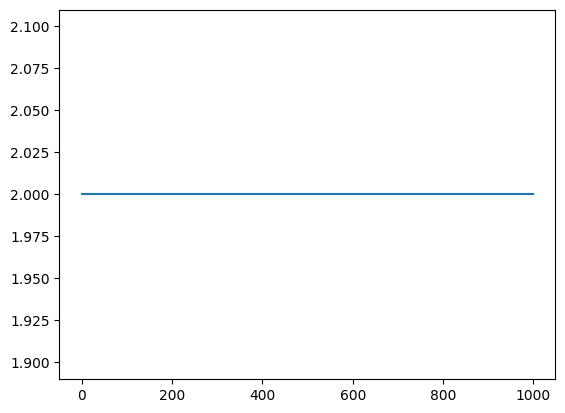

In [ ]:
test_q = [1, 2, 3, 2, 1] # pravimo vektor sa dobitima svih bandita

test_actions = [choose_greedy_action(test_q) for _ in range(test_len)] # gridi politika 1000 puta izvodimo ekpsperiment i bira bandita sa indeksom 2 jer ima najvecu dobit (3)

plt.plot(test_actions)

In [ ]:
# nasumicna politika, bira random kog ce izabrati bandita nije potrebno prosledjivati dobit bandita vec samo broj bandita
# eksplorativna politika, saynajemo o okolini, i necemo maksimizovati dobit, sa pohlepnom maksimizujemo dobit ali ne znamo kako ce se ponasati ostali banditi
def choose_random_action(n):
    return random.randint(0, n-1)

In [ ]:
# epsilon pohlepna, sa verovatnocom epsilom bira eksplorativno tj bira nasumicnu, sa verovatnocom 1-eps biramo pohlepno, sa malo eps biramo nasumicno sa veliko eps biramo gridi
# rendom nam vraca broj izmedju 0 i 1 i posto je sa uniformnom raspodelom svaki broj ima jednuku verovatnocu
# kod uniformne raspodele gustina tj povrsina treba da bude 1
# random ce biti generator verovatnoce, ako je on manje od eps , znaci da je verovatnoca eps
# ako je rand broj manji od eps to ce biti eps
# ako je rand broj veca od eps to ce biti 1-eps
# ako je verovatnoca eps ili manja od eps biramo slucajnu politiku ako je veca od eps biramo pohlepno
def choose_eps_greedy_action(q, eps):
    if random.random() > eps:
        return choose_greedy_action(q)
    else:
        return choose_random_action(len(q))

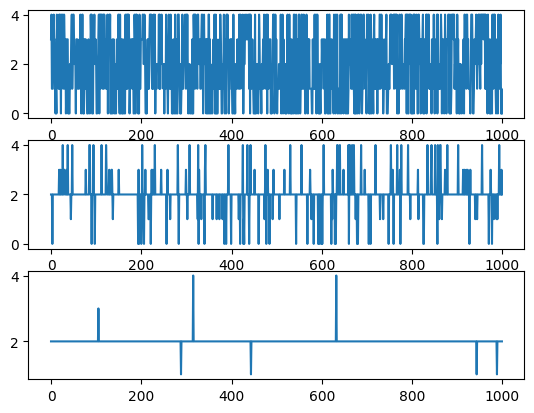

In [ ]:
# sada to testiramo
plt.subplot(3, 1, 1)
plt.plot([choose_eps_greedy_action(test_q, 1.0) for _ in range(test_len)]) # u prvom slucaju eps je 1, to znaci sig biramo nasumicno, ne pohlepno, politika bira nasumicno briga je koji je najbolji
plt.subplot(3, 1, 2)
plt.plot([choose_eps_greedy_action(test_q, 0.2) for _ in range(test_len)]) # sa 20% biramo nasumicno sa 80% biramo pohlepno
plt.subplot(3, 1, 3)
plt.plot([choose_eps_greedy_action(test_q, 0.01) for _ in range(test_len)]) # sa 1 % biramo nasumicno sa 99% biramo pohlepno i davace nam najbolje vrednosti, imacemo najveci dobitak, i tu dobro procenjujemo srednju vrednost
# ali za ostale nemamo info i ne mozemo proceniti sr vrednost

## Training Loop

In [ ]:
# test petlja
# sa povlacenjem rucice dobijam neku nagradu,
# formula sa q, ako je alfa vece, dozvoljavamo menjanje u sl iteraciji, vise pratimo uticaj okoline
# sto je manje alfa vise pratimo sebe a manje okolinu
BANDITS_NO = 5 # imamo 5 bandita
ATTEMPTS_NO = 5000 # 5000 iteracija
ALPHA = 0.1 # azurirace se ali cemo vise verovati sebi
EPSILON = 0.1 # oko 10% akcija ce biti nasumicno ostalih 90% gridi

# PRVI ZADATAK NA DOMACEM
# Kada stavimo da je EPSILON = 0.001, sa 0,1% akcije ce se nasumicno birati, a sa 99,9% pohlepnim algoritmom se bitraju akcije.
# sa plavom je oznaceno kako bi izgledalo da smo birali uvek bandita sa najvecom dobiti
# narandzasta je kako se mi ponasamo sa nasim algoritmom
# sto smo pohlepniji bicemo blizi, a s obzirom da se ponasamo skoro 100% pohlepno, bicemo sve blizi plavoj liniji
#EPSILON = 0.001


bandits = [Bandit(10*(random.random()-0.5), 5*random.random()) for _ in range(BANDITS_NO)] # kreiramo tako da srednja vr bude u opsegu od -5 do 5 i neki spend definisemo
env = BanditsEnvironment(bandits) # generisemo listu od 5 bandita i dodali u nase okruzenje

q = [100 for _ in range(BANDITS_NO)] # moramo definisati neku listu dobiti, ili tako sto pre testiranja alg povlacimo rucice svakog i procenimo srednje vrednosti
# ali u praksi se stavlja da svi banditi imaju istu dobit u pocetku da bi svi imali jednaku verovatnocu da budu izabrani
rewards = []
for t in trange(ATTEMPTS_NO): # prolazimo kroz iter

    a = choose_eps_greedy_action(q, EPSILON) # eps pohl prolazimo
    r = env.take_action(a) # take action poziva pull leaver i time dobijamo nagradu
    # na  osnovu nagrade azuriramo vrednost nase dobiti
    q[a] = q[a] + ALPHA * (r - q[a]) # kao kraj alg dobijamo vektor q koji je azuriran i svaki bandit ima neku svoju dobit
    # just for logging
    rewards.append(r) # cuvamo nagradu za svaku iter
    """#dodato za 3. zadatak
    if t == 4000:
        # Ažuriranje srednjih vrednosti i opsega bandita nakon 4000 iteracija
        for bandit in env.bandits:
            bandit.mean = 10 * (random.random() - 0.5)
            bandit.span = 5 * random.random()

# Nastavak petlje za preostale iteracije nakon ažuriranja bandita
for t in trange(4001, ATTEMPTS_NO):
    bandits = [Bandit(10*(random.random()-0.5), 5*random.random()) for _ in range(BANDITS_NO)]
    a = choose_eps_greedy_action(q, EPSILON)
    r = env.take_action(a)
    q[a] = q[a] + ALPHA * (r - q[a])
    rewards.append(r) # cuvamo nagradu za svaku iter"""
#
# drugi zadatak
# Postavljanje epsilon na 0 za narednih 100 iteracija
#EPSILON = 0
"""
# Probavanje 100 iteracija sa epsilon=0
for t in trange(100):
    a = choose_eps_greedy_action(q, EPSILON)
    r = env.take_action(a)
    q[a] = q[a] + ALPHA * (r - q[a])
    """



100%|██████████| 5000/5000 [00:00<00:00, 68260.00it/s]


'\n# Probavanje 100 iteracija sa epsilon=0\nfor t in trange(100):\n    a = choose_eps_greedy_action(q, EPSILON)\n    r = env.take_action(a)\n    q[a] = q[a] + ALPHA * (r - q[a])\n    '

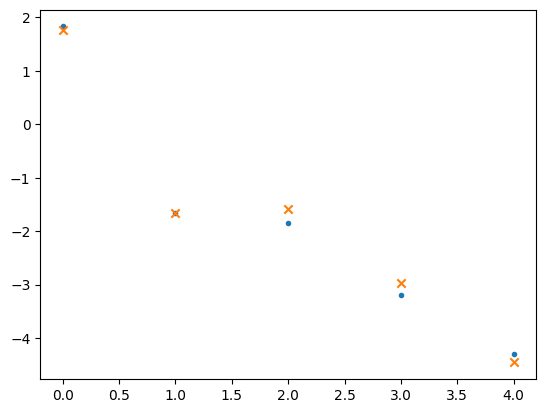

In [ ]:
# koliko se nasa procena sr vrednosti bandita poklapa sa stvarnom
plt.scatter(range(len(q)), q, marker=".") # q je procenjena srednja vrednsot nasa sa .
plt.scatter(range(len(q)), [b.mean for b in env.bandits], marker="x") # x je stvarna

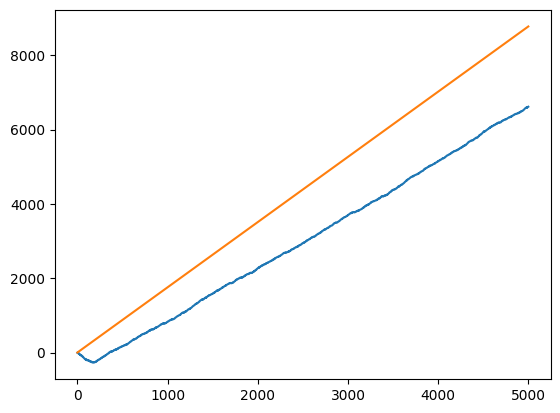

In [ ]:
# kumulativna suma od nagrada [1 5 8] --> [1 5 14]
g = np.cumsum(rewards)
max_r = max([b.mean for b in env.bandits])
plt.plot(g)
plt.plot(np.cumsum(max_r * np.ones(len(g))))
# sa plavom je oznaceno kako bi izgledala kako bi izgledalo da smo birali uvek bandita sa najvecom dobiti
# narandzasta je kako se mi ponasamo sa nasim alg
# sto smo pohlepniji bicemo blizi

1. Probati sa manjim epsilon, da se vidi da je manja razlika nagiba
2. Probati da uzmete nauceno q, i probati 100 iteracija sa epsilon = 0
3. Kako napraviti da se srednje vrednosti menjaju tokom vremena. Za pocetak samo da se nakon 4000 iteracija promene srednje vrednosti i spanovi bandita.
4. napraviti okruzenje bandita sa konacnim poznatim brojem bandita, ciji su parametri takodje poznati. prikazati graficki kako procenjene srednje dobiti q konvergiraju ka stvarnim srednjim dobitima za svakog bandita kroz iteracije.

# Prvi zadatak

In [ ]:

# Kada stavimo da je EPSILON = 0.001, sa 0,1% akcije ce se nasumicno birati, a sa 99,9% pohlepnim algoritmom se bitraju akcije.
# sa plavom je oznaceno kako bi izgledalo da smo birali uvek bandita sa najvecom dobiti
# narandzasta je kako se mi ponasamo sa nasim algoritmom
# sto smo pohlepniji bicemo blizi, a s obzirom da se ponasamo skoro 100% pohlepno, bicemo sve blizi plavoj liniji
#EPSILON = 0.001
BANDITS_NO = 5
ATTEMPTS_NO = 5000
ALPHA = 0.1
EPSILON = 0.001

bandits = [Bandit(10*(random.random()-0.5), 5*random.random()) for _ in range(BANDITS_NO)]
env = BanditsEnvironment(bandits)

q = [100 for _ in range(BANDITS_NO)]
rewards = []
for t in trange(ATTEMPTS_NO):
    a = choose_eps_greedy_action(q, EPSILON)
    r = env.take_action(a)
    q[a] = q[a] + ALPHA * (r - q[a])

    # just for logging
    rewards.append(r)


100%|██████████| 5000/5000 [00:00<00:00, 118010.46it/s]


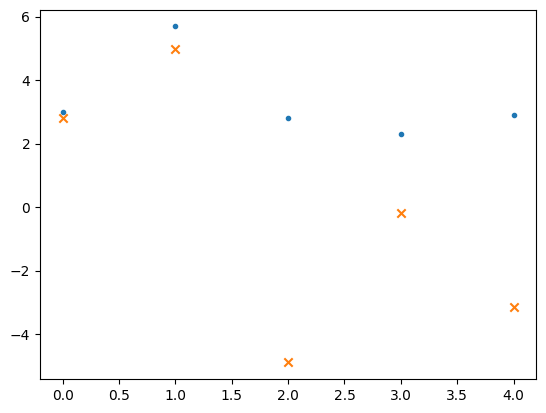

In [ ]:
plt.scatter(range(len(q)), q, marker=".")
plt.scatter(range(len(q)), [b.mean for b in env.bandits], marker="x")

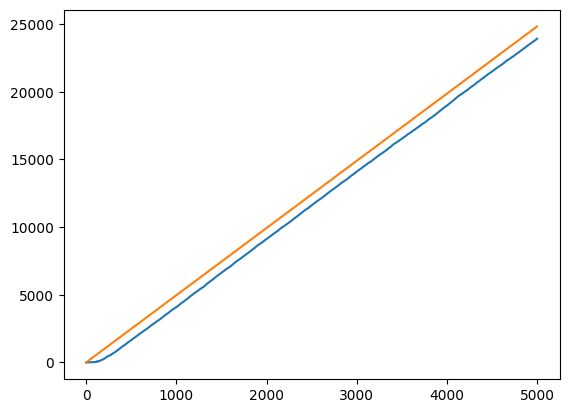

In [ ]:
g = np.cumsum(rewards)
max_r = max([b.mean for b in env.bandits])
plt.plot(g)
plt.plot(np.cumsum(max_r * np.ones(len(g))))

In [ ]:
# u prvom samo promeniti eps, kako se menja poslednji grafik
# drugi uzeti nauceno q, mi smo lupili vektor q q = [100 - ...]
# sada q prosledimo algoritmu, znaci ne uzimamo azuriranu vrednost nego te stare koristimo
# trece, u petlji kod q treba dodati da se nakon 4000 iter promeni sistem
# u cetvrtom kreiramo svoje okruzenje bandita, mozemo kreirati kako je bandits definisano, potrebno je zatim prikazati graficki kako konvergiraju tj
# q[a] = q[a] .. tu je potrebno da vidimo kako je iskonvergirao x na .
# potrebno je napraviti vektor vektora da vbi videli kako x izgleda u svakoj iter, u svakoj iter azuriramo q i treba cuvati prethodne iz vektora
# za prvog bandita pristupim njegovim prethodnicima uzimam npr za prvog bandita uzimam vrednosti prvog bandita u svakoj iter
# i to treba plotovati

# 1. uradjen
# 2. promenili smo epsilon i broj iter, i q da se uzima nauceno za narednih 100 iter, da li je dobro?
# 3. proveriti sa asis da li je dobro uradjeno proveriti gde treba da bude rewards.append(r)

# Drugi zadatak

In [ ]:
BANDITS_NO = 5
ATTEMPTS_NO = 5000
ALPHA = 0.1
EPSILON = 0

bandits = [Bandit(10*(random.random()-0.5), 5*random.random()) for _ in range(BANDITS_NO)]
env = BanditsEnvironment(bandits)

#q = [100 for _ in range(BANDITS_NO)]
learned_q = q.copy()
greedy_rewards = []
for _ in range(100):
    a = choose_greedy_action(learned_q)
    r = env.take_action(a)
    greedy_rewards.append(r)

avg_rewards_eps_greedy = np.mean(rewards)
avg_rewards_greedy = np.mean(greedy_rewards)
print("Prosečna nagrada - ε-Greedy Politika:", avg_rewards_eps_greedy)
print("Prosečna nagrada - Čista Greedy Politika:", avg_rewards_greedy)
    # just for logging

Prosečna nagrada - ε-Greedy Politika: 4.784142055608764
Prosečna nagrada - Čista Greedy Politika: -0.564078397676991


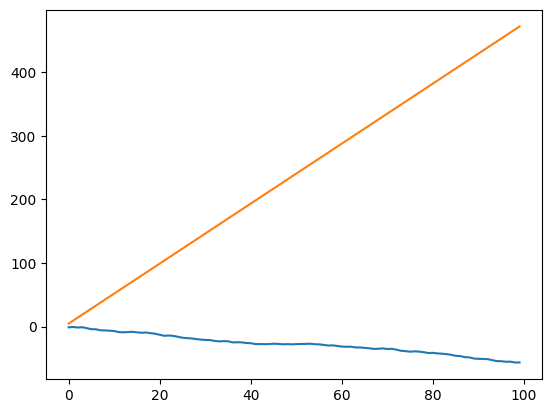

In [ ]:
g = np.cumsum(greedy_rewards)
max_r = max([b.mean for b in env.bandits])
plt.plot(g)
plt.plot(np.cumsum(max_r * np.ones(len(g))))

100%|██████████| 5000/5000 [00:00<00:00, 140918.69it/s]


Learned Q values: [-3.3977120326010986, -4.533453346405382, -1.480236907702317, -3.1297756168644493, -2.9267117354652616]
Test mean reward: -1.4743703741753311
Ideal mean reward: -1.4745406426038328


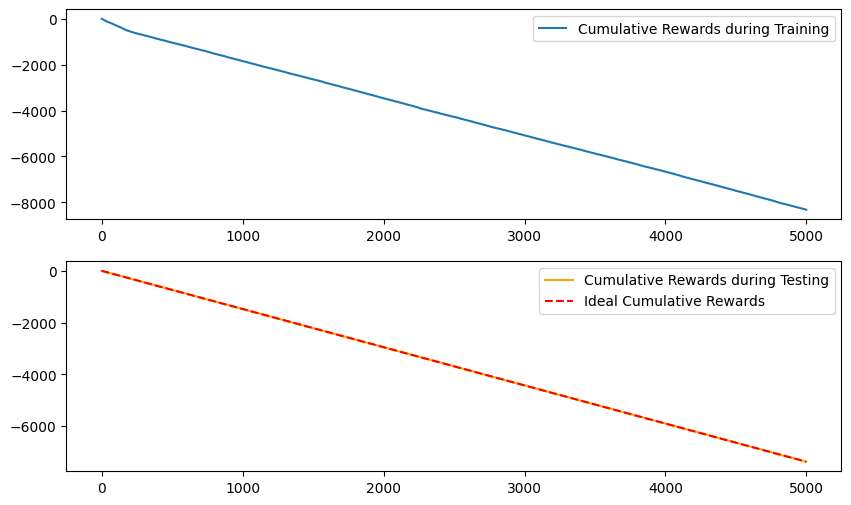

In [ ]:
BANDITS_NO = 5
ATTEMPTS_NO = 5000
ALPHA = 0.1
EPSILON = 0.1

bandits = [Bandit(10*(random.random()-0.5), 5*random.random()) for _ in range(BANDITS_NO)]
env = BanditsEnvironment(bandits)

q = [100 for _ in range(BANDITS_NO)]
rewards = []

# Training loop
for t in trange(ATTEMPTS_NO):
    a = choose_eps_greedy_action(q, EPSILON)
    r = env.take_action(a)
    q[a] = q[a] + ALPHA * (r - q[a])

    # Just for logging
    rewards.append(r)

# Test loop
test_rewards = [env.take_action(choose_greedy_action(q)) for _ in range(ATTEMPTS_NO)]
test_mean = sum(test_rewards) / ATTEMPTS_NO

# Ideal performance (maximum mean reward)
ideal_rewards = [max([b.mean for b in env.bandits]) for _ in range(ATTEMPTS_NO)]
ideal_mean = sum(ideal_rewards) / ATTEMPTS_NO

# Print results
print("Learned Q values:", q)
print("Test mean reward:", test_mean)
print("Ideal mean reward:", ideal_mean)

# Plotting results
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(np.cumsum(rewards), label="Cumulative Rewards during Training")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(np.cumsum(test_rewards), label="Cumulative Rewards during Testing", color="orange")
plt.plot(np.cumsum(ideal_rewards), label="Ideal Cumulative Rewards", linestyle="--", color="red")
plt.legend()

plt.show()


# treci zadatak

In [ ]:
# test petlja
# sa povlacenjem rucice dobijam neku nagradu,
# formula sa q, ako je alfa vece, dozvoljavamo menjanje u sl iteraciji, vise pratimo uticaj okoline
# sto je manje alfa vise pratimo sebe a manje okolinu
BANDITS_NO = 5 # imamo 5 bandita
ATTEMPTS_NO = 5000 # 5000 iteracija
ALPHA = 0.1 # azurirace se ali cemo vise verovati sebi
EPSILON = 0.1 # oko 10% akcija ce biti nasumicno ostalih 90% gridi


bandits = [Bandit(10*(random.random()-0.5), 5*random.random()) for _ in range(BANDITS_NO)] # kreiramo tako da srednja vr bude u opsegu od -5 do 5 i neki spend definisemo
env = BanditsEnvironment(bandits) # generisemo listu od 5 bandita i dodali u nase okruzenje

q = [100 for _ in range(BANDITS_NO)] # moramo definisati neku listu dobiti, ili tako sto pre testiranja alg povlacimo rucice svakog i procenimo srednje vrednosti
# ali u praksi se stavlja da svi banditi imaju istu dobit u pocetku da bi svi imali jednaku verovatnocu da budu izabrani
rewards = []
for t in trange(ATTEMPTS_NO): # prolazimo kroz iter

    a = choose_eps_greedy_action(q, EPSILON) # eps pohl prolazimo
    r = env.take_action(a) # take action poziva pull leaver i time dobijamo nagradu
    # na  osnovu nagrade azuriramo vrednost nase dobiti
    q[a] = q[a] + ALPHA * (r - q[a]) # kao kraj alg dobijamo vektor q koji je azuriran i svaki bandit ima neku svoju dobit
    # just for logging
    rewards.append(r) # cuvamo nagradu za svaku iter
    #dodato za 3. zadatak
    if t == 4000:
        # Ažuriranje srednjih vrednosti i opsega bandita nakon 4000 iteracija
        for bandit in env.bandits:
            bandit.mean = 10 * (random.random() - 0.5)
            bandit.span = 5 * random.random()

# Nastavak petlje za preostale iteracije nakon ažuriranja bandita
for t in trange(4001, ATTEMPTS_NO):
    bandits = [Bandit(10*(random.random()-0.5), 5*random.random()) for _ in range(BANDITS_NO)]
    a = choose_eps_greedy_action(q, EPSILON)
    r = env.take_action(a)
    q[a] = q[a] + ALPHA * (r - q[a])
    rewards.append(r) # cuvamo nagradu za svaku iter



100%|██████████| 999/999 [00:00<00:00, 65153.86it/s]


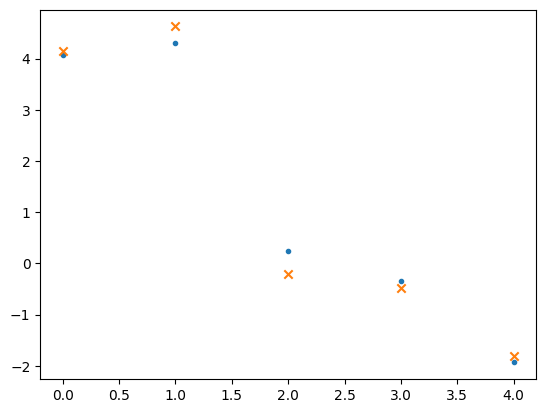

In [ ]:
# koliko se nasa procena sr vrednosti bandita poklapa sa stvarnom
plt.scatter(range(len(q)), q, marker=".") # q je procenjena srednja vrednsot nasa sa .
plt.scatter(range(len(q)), [b.mean for b in env.bandits], marker="x") # x je stvarna

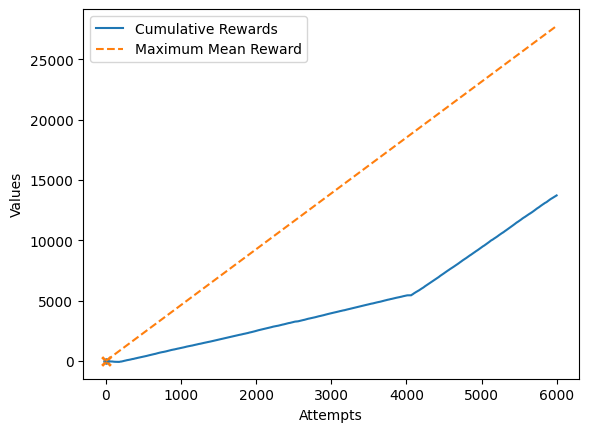

In [ ]:
# Ispisujemo promene procenjenih vrednosti q tokom vremena
plt.scatter(range(len(q)), q, marker=".")
plt.scatter(range(len(q)), [b.mean for b in env.bandits], marker="x")

# Ispisujemo kumulativne nagrade tokom vremena
g = np.cumsum(rewards)
max_r = max([b.mean for b in env.bandits])
plt.plot(g, label="Cumulative Rewards")
plt.plot(np.cumsum(max_r * np.ones(len(g))), label="Maximum Mean Reward", linestyle="--")

# Postavljamo oznake i legendu
plt.xlabel("Attempts")
plt.ylabel("Values")
plt.legend()

# Prikazujemo grafikone
plt.show()



Odskakanje nakon 4000 iteracija:  2.5048498431237287


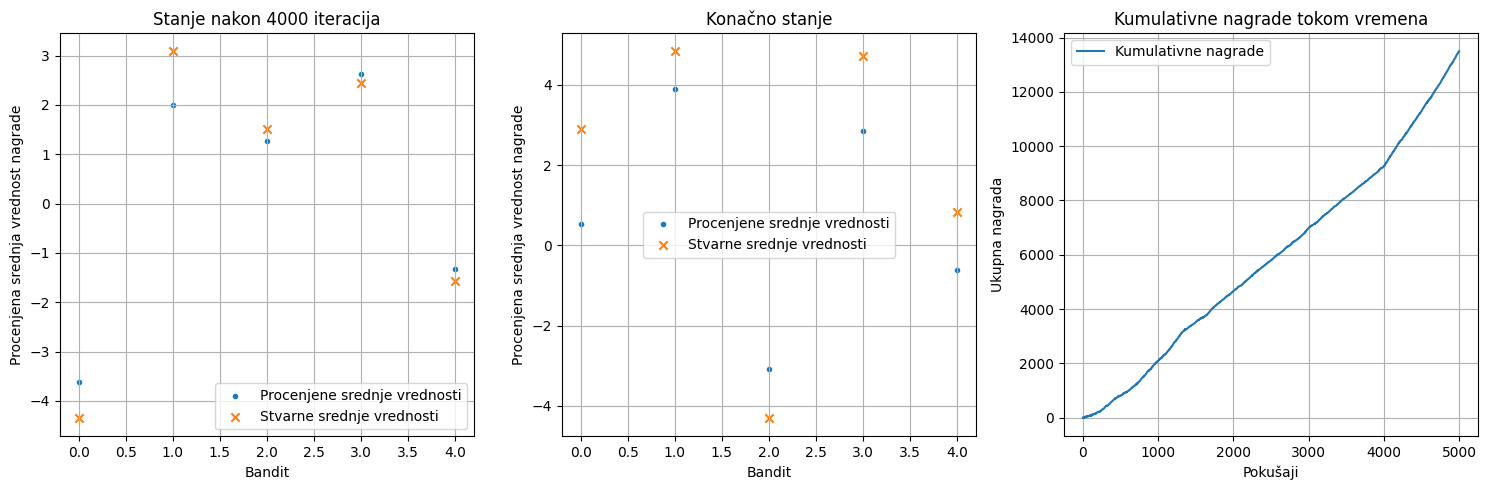


Konačno odstupanje:  7.8632010327352635


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

class Bandit:
    def __init__(self, mean, span):
        self.mean = mean
        self.span = span

class BanditsEnvironment:
    def __init__(self, bandits):
        self.bandits = bandits

    def take_action(self, action):
        return np.random.normal(self.bandits[action].mean, self.bandits[action].span)

def choose_eps_greedy_action(q, epsilon):
    if np.random.random() < epsilon:
        return np.random.randint(len(q))
    else:
        return np.argmax(q)

def loss_function(q, envi):
    """
    Calculates the total deviation of the estimated mean values from the actual mean values of the bandits.

    Args:
        q (List[float]): Estimated mean values (Q-values).
        envi (BanditsEnvironment): The bandits environment.

    Returns:
        float: The total deviation.
    """
    loss = 0
    m = [b.mean for b in envi.bandits]
    for a in range(len(q)):
        loss += abs(q[a] - m[a])
    return loss

BANDITS_NO = 5  # imamo 5 bandita
ATTEMPTS_NO = 5000  # 5000 iteracija
ALPHA = 0.1  # azurirace se ali cemo vise verovati sebi
EPSILON = 0.1  # oko 10% akcija ce biti nasumicno ostalih 90% gridi

bandits = [Bandit(10 * (np.random.random() - 0.5), 5 * np.random.random()) for _ in range(BANDITS_NO)]  # kreiramo tako da srednja vr bude u opsegu od -5 do 5 i neki spend definisemo
env = BanditsEnvironment(bandits)  # generisemo listu od 5 bandita i dodali u nase okruzenje

q = [100 for _ in range(BANDITS_NO)]  # moramo definisati neku listu dobiti, ili tako sto pre testiranja alg povlacimo rucice svakog i procenimo srednje vrednosti
# ali u praksi se stavlja da svi banditi imaju istu dobit u pocetku da bi svi imali jednaku verovatnocu da budu izabrani
rewards = []

# Iscrtavanje prvog grafa
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("Stanje nakon 4000 iteracija")
plt.xlabel("Bandit")
plt.ylabel("Procenjena srednja vrednost nagrade")
plt.grid(True)

for t in range(ATTEMPTS_NO):  # prolazimo kroz iter
    if t == 4000:
        # Dodajemo podatke na grafikon
        plt.scatter(range(len(q)), q, marker=".", label="Procenjene srednje vrednosti")
        plt.scatter(
            range(len(q)),
            [b.mean for b in env.bandits],
            marker="x",
            label="Stvarne srednje vrednosti",
        )
        plt.legend()
        print("\nOdskakanje nakon 4000 iteracija: ", loss_function(q, env))
        # Kreiranje novih bandita (m, s)
        bandits = [
            Bandit(10 * (np.random.random() - 0.5), 5 * np.random.random())
            for _ in range(BANDITS_NO)
        ]
        env = BanditsEnvironment(bandits)

    a = choose_eps_greedy_action(q, EPSILON)  # eps pohl prolazimo
    r = env.take_action(a)  # take action poziva pull leaver i time dobijamo nagradu
    # na  osnovu nagrade azuriramo vrednost nase dobiti
    q[a] = q[a] + ALPHA * (r - q[a])  # kao kraj alg dobijamo vektor q koji je azuriran i svaki bandit ima neku svoju dobit
    rewards.append(r)  # cuvamo nagradu za svaku iter

    if t == 4000:
        # Ažuriranje srednjih vrednosti i opsega bandita nakon 4000 iteracija
        for bandit in env.bandits:
            bandit.mean = 10 * (np.random.random() - 0.5)
            bandit.span = 5 * np.random.random()

# Iscrtavanje drugog grafa
plt.subplot(1, 3, 2)
plt.title("Konačno stanje")
plt.xlabel("Bandit")
plt.ylabel("Procenjena srednja vrednost nagrade")
plt.grid(True)
plt.scatter(range(len(q)), q, marker=".", label="Procenjene srednje vrednosti")
plt.scatter(
    range(len(q)),
    [b.mean for b in env.bandits],
    marker="x",
    label="Stvarne srednje vrednosti",
)
plt.legend()

# Iscrtavanje trećeg grafa
plt.subplot(1, 3, 3)
plt.title("Kumulativne nagrade tokom vremena")
plt.xlabel("Pokušaji")
plt.ylabel("Ukupna nagrada")
plt.grid(True)
g = np.cumsum(rewards)
plt.plot(g, label="Kumulativne nagrade")
plt.legend()

plt.tight_layout()

plt.show()

print("\nKonačno odstupanje: ", loss_function(q, env))


U zaključku trećeg zadatka možemo primetiti da povećanje pomeraja srednjih vrednosti i raspona nagrada predstavlja izazov za algoritam u praćenju optimalnih nagrada. Ovo je posebno izraženo u kasnijim iteracijama, što sugeriše da algoritam ima teškoća u prilagođavanju promenama koje se dešavaju često ili su značajne. Sa povećanjem pomeraja, algoritam češće donosi pogrešne odluke u identifikaciji stvarno najboljeg bandita. Ova pojava može biti rezultat algoritma koji više veruje u procene zasnovane na prethodnim iskustvima, koje postaju manje pouzdane kako se česte promene nagrada dešavaju. Međutim, uprkos izazovima u praćenju najboljeg bandita, algoritam pokazuje sposobnost da identifikuje novog najboljeg bandita nakon promena. Vreme potrebno algoritmu da pronađe novog najboljeg bandita može biti pokazatelj njegove efikasnosti u učenju i adaptaciji.

# cetvrti zadatak

100%|██████████| 1000/1000 [00:00<00:00, 102440.02it/s]


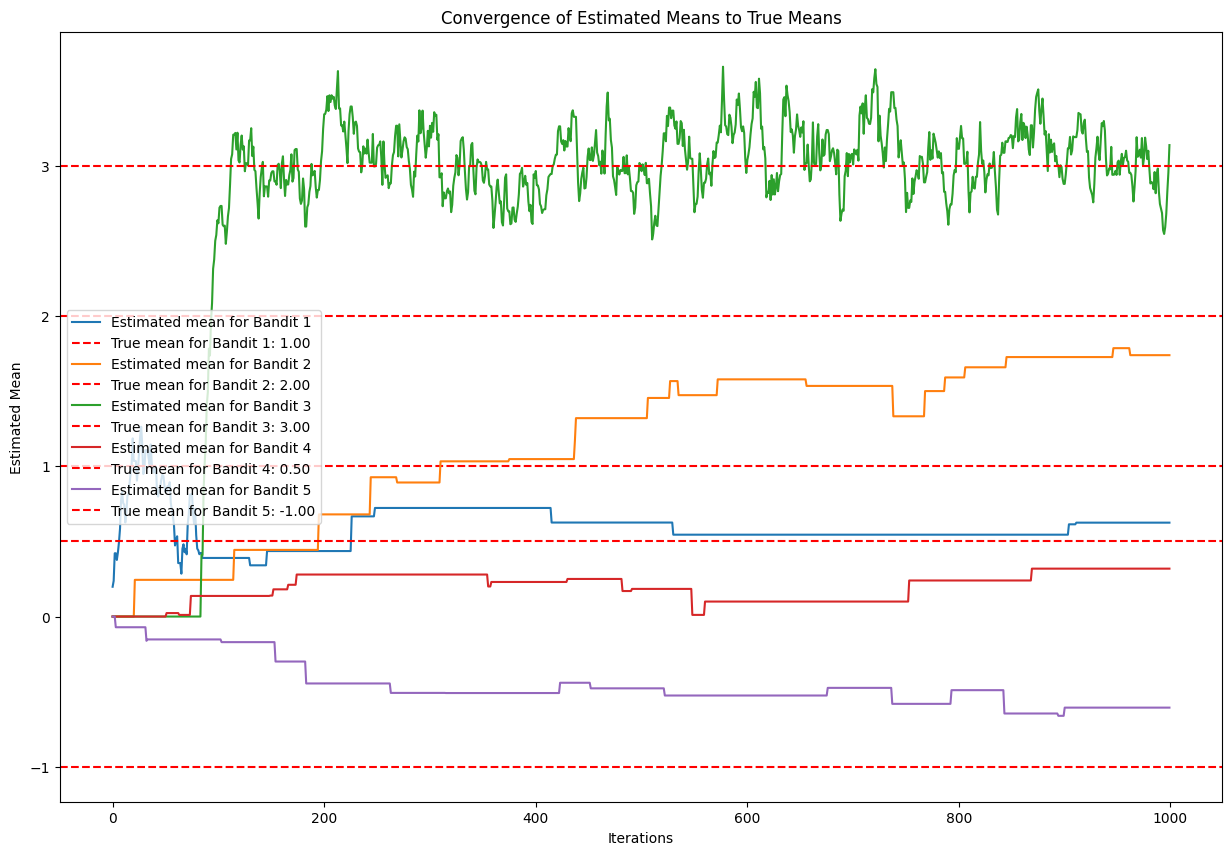

In [ ]:
from typing import Iterable
import random

import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

class Bandit:
    """A bandit with a known mean reward."""

    def __init__(self, true_mean: float):
        """Initialize the bandit.

        Args:
            true_mean (float): True mean (expected value) of the reward.
        """
        self.true_mean = true_mean
        self.estimated_mean = 0  # Initial estimated mean
        self.num_pulls = 0  # Counter for the number of pulls

    def pull_lever(self) -> float:
        """Pull leaver and obtain reward.

        Returns:
            float: The obtained reward.
        """
        reward = self.true_mean + np.random.normal()  # Gaussian noise for randomness
        self.num_pulls += 1
        self.estimated_mean = ((self.num_pulls - 1) * self.estimated_mean + reward) / self.num_pulls
        return reward

class BanditsEnvironment:
    """An environment consisting of multiple bandits with known parameters."""

    def __init__(self, bandits: Iterable[Bandit]):
        """Initialize the environment.

        Args:
            bandits (iter[Bandit]): Bandits to be used within the environment.
        """
        self.bandits: list[Bandit] = list(bandits)

    def take_action(self, a: int):
        """
        Select bandit `a` and pull its leaver.

        Return the obtained reward.
        """
        return self.bandits[a].pull_lever()

def plot_bandit_means(bandits: list[Bandit], q_value_history: np.ndarray):
    plt.figure(figsize=(15, 10))
    for i in range(len(bandits)):
        plt.plot(q_value_history[:, i], label=f"Estimated mean for Bandit {i + 1}")
        plt.axhline(
            y=bandits[i].true_mean,
            color="r",
            linestyle="--",
            label=f"True mean for Bandit {i + 1}: {bandits[i].true_mean:.2f}",
        )
        plt.legend()
    plt.title("Convergence of Estimated Means to True Means")
    plt.xlabel("Iterations")
    plt.ylabel("Estimated Mean")
    plt.show()

# Inicijalizacija bandita sa poznatim srednjim vrednostima
bandit_means = [1.0, 2.0, 3.0, 0.5, -1.0]
bandits = [Bandit(true_mean) for true_mean in bandit_means]
env = BanditsEnvironment(bandits)

# Parametri za trening
ATTEMPTS_NO = 1000
ALPHA = 0.1

# Inicijalizacija Q-vrednosti
q = np.zeros(len(bandits))
q_value_history = np.zeros((ATTEMPTS_NO, len(bandits)))

# Trening petlja
for t in trange(ATTEMPTS_NO):
    a = choose_eps_greedy_action(q, EPSILON)
    r = env.take_action(a)
    q[a] = q[a] + ALPHA * (r - q[a])

    # Logovanje Q-vrednosti
    q_value_history[t] = q

# Prikaz rezultata
plot_bandit_means(bandits, q_value_history)


100%|██████████| 1000/1000 [00:00<00:00, 37251.58it/s]


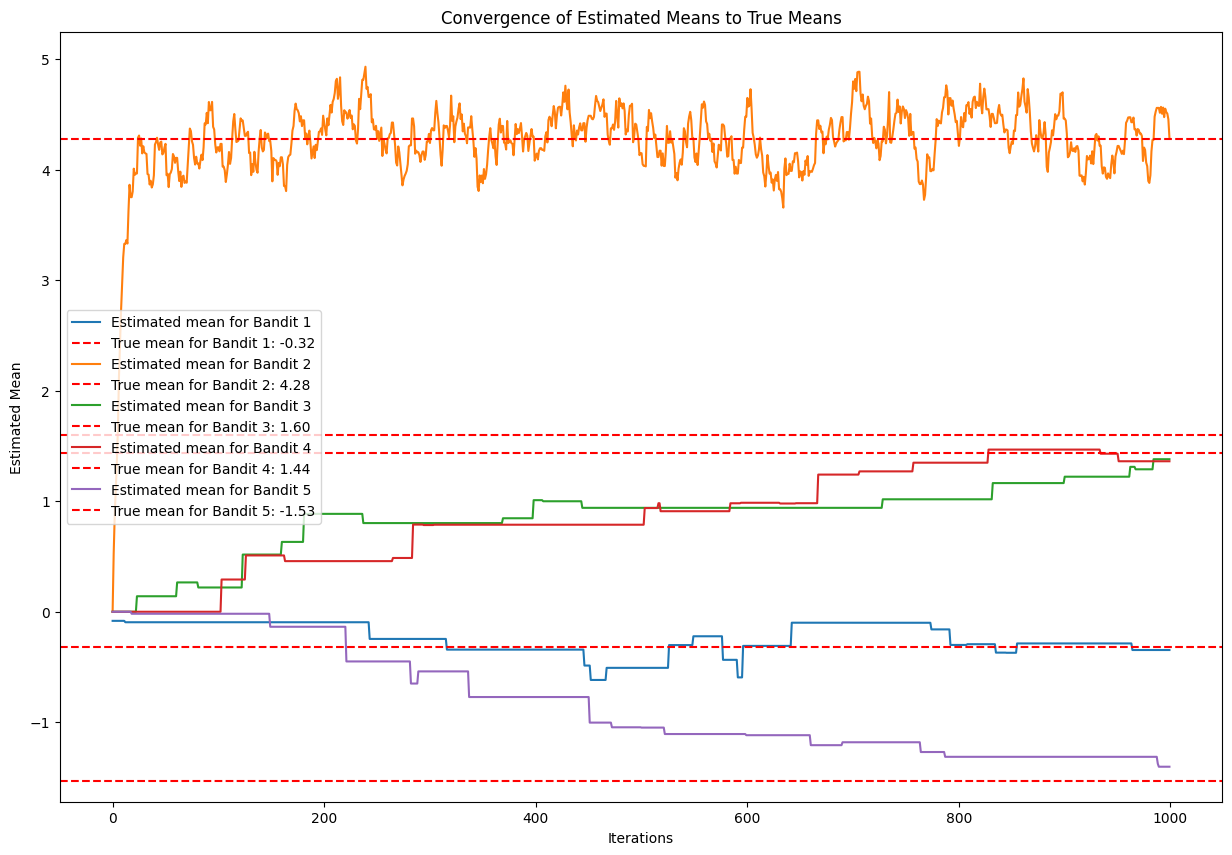

In [ ]:
from typing import Iterable
import random

import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

class Bandit:
    """A bandit with a known mean reward."""

    def __init__(self, true_mean: float):
        """Initialize the bandit.

        Args:
            true_mean (float): True mean (expected value) of the reward.
        """
        self.true_mean = true_mean
        self.estimated_mean = 0  # Initial estimated mean
        self.num_pulls = 0  # Counter for the number of pulls

    def pull_lever(self) -> float:
        """Pull leaver and obtain reward.

        Returns:
            float: The obtained reward.
        """
        reward = self.true_mean + np.random.normal()  # Gaussian noise for randomness
        self.num_pulls += 1
        self.estimated_mean = ((self.num_pulls - 1) * self.estimated_mean + reward) / self.num_pulls
        return reward

class BanditsEnvironment:
    """An environment consisting of multiple bandits with known parameters."""

    def __init__(self, bandits: Iterable[Bandit]):
        """Initialize the environment.

        Args:
            bandits (iter[Bandit]): Bandits to be used within the environment.
        """
        self.bandits: list[Bandit] = list(bandits)

    def take_action(self, a: int):
        """
        Select bandit `a` and pull its leaver.

        Return the obtained reward.
        """
        return self.bandits[a].pull_lever()

def plot_bandit_means(bandits: list[Bandit], q_value_history: np.ndarray):
    plt.figure(figsize=(15, 10))
    for i in range(len(bandits)):
        plt.plot(q_value_history[:, i], label=f"Estimated mean for Bandit {i + 1}")
        plt.axhline(
            y=bandits[i].true_mean,
            color="r",
            linestyle="--",
            label=f"True mean for Bandit {i + 1}: {bandits[i].true_mean:.2f}",
        )
        plt.legend()
    plt.title("Convergence of Estimated Means to True Means")
    plt.xlabel("Iterations")
    plt.ylabel("Estimated Mean")
    plt.show()

# Inicijalizacija bandita sa nasumičnim srednjim vrednostima
bandit_means = [random.uniform(-5, 5) for _ in range(5)]
bandits = [Bandit(true_mean) for true_mean in bandit_means]
env = BanditsEnvironment(bandits)

# Parametri za trening
ATTEMPTS_NO = 1000
ALPHA = 0.1
EPSILON = 0.1

# Inicijalizacija Q-vrednosti
q = np.zeros(len(bandits))
q_value_history = np.zeros((ATTEMPTS_NO, len(bandits)))

# Trening petlja
for t in trange(ATTEMPTS_NO):
    a = choose_eps_greedy_action(q, EPSILON)
    r = env.take_action(a)
    q[a] = q[a] + ALPHA * (r - q[a])

    # Logovanje Q-vrednosti
    q_value_history[t] = q

# Prikaz rezultata
plot_bandit_means(bandits, q_value_history)
